In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 

os.chdir('../')
#os.chdir('../')

from python.create_dgl_dataset import TelemacDataset
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.CustomMeshGraphNet import MeshGraphNet

import torch
from dgl.dataloading import GraphDataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.nn.parallel import DistributedDataParallel
import time, os
import wandb as wb
import dgl

In [2]:
try:
    import apex
except:
    pass

#from modulus.models.meshgraphnet import MeshGraphNet
from modulus.distributed.manager import DistributedManager

from modulus.launch.logging import (
    PythonLogger,
    initialize_wandb,
    RankZeroLoggingWrapper,
)
from modulus.launch.utils import load_checkpoint, save_checkpoint
from python.constants import Constants

In [3]:
print(os.environ['WORLD_SIZE'])
print(os.environ['MASTER_PORT'])
print(os.environ['MASTER_ADDR'])
print(os.environ['RANK'])
print(os.environ['LOCAL_RANK'])

1
55887
gpu-nc05
0
0


In [ ]:
print(os.environ['WORLD_SIZE'])

In [ ]:
DistributedManager.initialize()
dist = DistributedManager()
print(dist.rank)
print(dist.local_rank)
print(dist.world_size)
print(dist.device)

In [3]:
# Instantiate constants
C = Constants()

In [4]:
dataset = TelemacDataset(
            name="telemac_train",
            data_dir=C.data_dir,
            split="train",
            num_samples=C.num_training_samples,
            num_steps=C.num_training_time_steps,
        )
#dataset._get_node_stats()

{'h': tensor([0.0332]), 'u': tensor([-0.0002]), 'v': tensor([0.0405]), 'strickler': tensor([16.2530]), 'z': tensor([-0.5487]), 'delta_h': tensor([0.0005]), 'delta_u': tensor([-1.2126e-05]), 'delta_v': tensor([0.0007]), 'h_std': tensor([0.1278]), 'u_std': tensor([0.0324]), 'v_std': tensor([0.1857]), 'strickler_std': tensor([7.2366]), 'z_std': tensor([0.8599]), 'delta_h_std': tensor([0.0081]), 'delta_u_std': tensor([0.0161]), 'delta_v_std': tensor([0.0322])}


In [5]:

class MGNTrainer:
    def __init__(self, wb, dist):#, rank_zero_logger):
        self.dist = dist
        print(os.getcwd())
        # instantiate dataset

        dataset = TelemacDataset(
            name="telemac_train",
            data_dir=C.data_dir,
            split="train",
            num_samples=C.num_training_samples,
            num_steps=C.num_training_time_steps,
        )

        # instantiate dataloader
        self.dataloader = GraphDataLoader(
            dataset,
            batch_size=C.batch_size,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
            use_ddp=dist.world_size > 1,
        )

        # instantiate the model
        self.model = MeshGraphNet(
            C.num_input_features, C.num_edge_features, C.num_output_features,processor_size=4,hidden_dim_processor=64,hidden_dim_node_encoder=64,hidden_dim_edge_encoder=64,hidden_dim_node_decoder=64,do_concat_trick=True
        )
        if C.jit:
            self.model = torch.jit.script(self.model).to(dist.device)
        else:
            self.model = self.model.to(dist.device)
        if C.watch_model and not C.jit and dist.rank == 0:
            wb.watch(self.model)

        # distributed data parallel for multi-node training
        if dist.world_size > 1:
            self.model = DistributedDataParallel(
                self.model,
                device_ids=[dist.local_rank],
                output_device=dist.device,
                broadcast_buffers=dist.broadcast_buffers,
                find_unused_parameters=dist.find_unused_parameters,
            )

        # enable train mode
        self.model.train()

        # instantiate loss, optimizer, and scheduler
        self.criterion = torch.nn.MSELoss()
        try:
            self.optimizer = apex.optimizers.FusedAdam(self.model.parameters(), lr=C.lr)
            #rank_zero_logger.info("Using FusedAdam optimizer")
        except:
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=C.lr)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.optimizer, lr_lambda=lambda epoch: C.lr_decay_rate**epoch
        )
        self.scaler = GradScaler()

        #load checkpoint
        if dist.world_size > 1:
            torch.distributed.barrier()
            self.epoch_init = load_checkpoint(
            os.path.join(C.ckpt_path, C.ckpt_name),
            models=self.model,
            optimizer=self.optimizer,
            scheduler=self.scheduler,
            scaler=self.scaler,
            device=dist.device,
        )
        self.epoch_init=0

    def train(self, graph):
        graph = graph.to(self.dist.device)
        self.optimizer.zero_grad()
        loss = self.forward(graph)
        self.backward(loss)
        self.scheduler.step()
        return loss

    def forward(self, graph):
        # forward pass
        with autocast(enabled=C.amp):
            pred = self.model(graph.ndata["x"], graph.edata["x"], graph)
            loss = self.criterion(pred, graph.ndata["y"])
            return loss

    def backward(self, loss):
        # backward pass
        if C.amp:
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
        else:
            loss.backward()
            self.optimizer.step()

In [6]:
loss_list = []
if __name__ == "__main__":
    # initialize distributed manager
    DistributedManager.initialize()
    dist = DistributedManager()
    print(dist.world_size)

    # save constants to JSON file
    if dist.rank == 0:
        os.makedirs(C.ckpt_path, exist_ok=True)
        with open(
            os.path.join(C.ckpt_path, C.ckpt_name.replace(".pt", ".json")), "w"
        ) as json_file:
            json_file.write(C.json(indent=4))



    trainer = MGNTrainer(wb, dist)#, rank_zero_logger)
    start = time.time()
    global_start = time.time()
    for epoch in range(trainer.epoch_init, C.epochs):
        global_loss = 0
        for graph in trainer.dataloader:
            loss = trainer.train(graph)
            global_loss += loss.detach().cpu().item()
        global_loss = global_loss/trainer.dataloader.dataset.length
        
        if epoch%10 ==0 :
            print(
                f"epoch: {epoch}, loss: {global_loss:10.3e}, time per epoch: {(time.time()-start):10.3e}"
            )
        loss_list.append(global_loss)
        
        # save checkpoint
        if dist.world_size > 1:
            torch.distributed.barrier()
        #if dist.rank == 0:
        #    save_checkpoint(
        #        os.path.join(C.ckpt_path, C.ckpt_name),
        #        models=trainer.model,
        #        optimizer=trainer.optimizer,
        #        scheduler=trainer.scheduler,
        #        scaler=trainer.scaler,
        #        epoch=epoch,
        #    )
        start = time.time()
    
    print(
            f"global time per epoch: {(time.time()-global_start)/C.epochs:10.3e}"
        )

1
/users/daml/vmercier
{'h': tensor([0.0332]), 'u': tensor([-0.0002]), 'v': tensor([0.0405]), 'strickler': tensor([16.2530]), 'z': tensor([-0.5487]), 'delta_h': tensor([0.0005]), 'delta_u': tensor([-1.2126e-05]), 'delta_v': tensor([0.0007]), 'h_std': tensor([0.1278]), 'u_std': tensor([0.0324]), 'v_std': tensor([0.1857]), 'strickler_std': tensor([7.2366]), 'z_std': tensor([0.8599]), 'delta_h_std': tensor([0.0081]), 'delta_u_std': tensor([0.0161]), 'delta_v_std': tensor([0.0322])}
epoch: 0, loss:  1.073e-01, time per epoch:  8.046e+00
epoch: 10, loss:  9.767e-02, time per epoch:  4.244e+00
epoch: 20, loss:  9.745e-02, time per epoch:  4.318e+00
epoch: 30, loss:  9.553e-02, time per epoch:  4.345e+00
epoch: 40, loss:  9.460e-02, time per epoch:  4.304e+00
global time per epoch:  4.385e+00


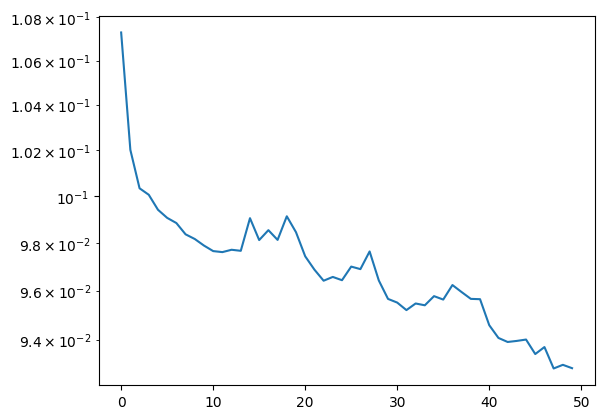

In [7]:
plt.yscale('log')
plt.plot(loss_list)

In [8]:
#import pickle
#with open(C.ckpt_path+'/losslist', "wb") as fp:   #Pickling
#    pickle.dump(loss_list, fp)

#plt.yscale('log')
#plt.plot(loss_list)


In [9]:
#dataset = TelemacDataset(
#            name="telemac_train",
#            data_dir=C.data_dir,
#            split="train",
#            num_samples=C.num_training_samples,
#            num_steps=C.num_training_time_steps,
#        )
ts =1
var = 0

In [10]:
results = trainer.model(dataset[ts].ndata["x"].to(dist.device), dataset[ts].edata["x"].to(dist.device), dataset[ts].to(dist.device)).detach().to('cpu').numpy()

In [11]:
test = dataset[ts].ndata["y"].detach().numpy()

In [12]:
from python.create_dgl_dataset import add_mesh_info
mesh_list = ['./vmercier/telemac_bdd_process/data/simulations/toy_test_case/maillage.slf']
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)

TelemacException: Could not find ./vmercier/telemac_bdd_process/data/simulations/toy_test_case/maillage.slf

In [ ]:
test = dataset[ts].ndata["y"].detach().numpy()

vmin = min(np.min(results[:,var]),np.min(test[:,var]))
vmax = min(np.max(results[:,var]),np.max(test[:,var]))

fig, ax = plt.subplots(2,1, figsize=(8, 10))
ax[0].tripcolor(X[:,0],X[:,1],results[:,var],triangles=triangles,vmin=vmin,vmax=vmax)
ax[1].tripcolor(X[:,0],X[:,1],test[:,var],triangles=triangles,vmin=vmin,vmax=vmax)
plt.show()

In [ ]:
print(np.max(results[:,var]))
print(np.max(test[:,var]))

print(np.min(results[:,var]))
print(np.min(test[:,var]))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 10))
clp = ax.tripcolor(X[:,0],X[:,1],np.abs(results[:,0]-test[:,0]),triangles=triangles,vmin=vmin,vmax=vmax)
fig.colorbar(clp)
plt.show()
arraytest = np.abs((results[:,0]-test[:,0]))
y = np.sort(arraytest) # sort array
y = y[::-1] # reverse sort order
print(y[0:400])

In [ ]:
prevision_1_step = np.zeros((720,dataset[ts].ndata["x"].shape[0]))
groundtruth = np.zeros((720,dataset[ts].ndata["x"].shape[0]))

for ts in range(720):
    results = trainer.model(dataset[ts].ndata["x"].to(dist.device), dataset[ts].edata["x"].to(dist.device), dataset[ts].to(dist.device)).detach().to('cpu').numpy()[:,0]
    prevision_1_step[ts,:]=results
    test = dataset[ts].ndata["y"].detach().numpy()[:,0]
    groundtruth[ts,:]=test

In [ ]:
np.mean(np.abs(prevision_1_step-groundtruth))

In [ ]:
np.argmax(np.abs(prevision_1_step-groundtruth))

In [ ]:
np.abs(prevision_1_step-groundtruth).shape

In [ ]:
np.unravel_index(np.abs(prevision_1_step-groundtruth).argmax(), np.abs(prevision_1_step-groundtruth).shape)